In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib 
#%matplotlib widget

In [2]:
data = pd.read_csv('TTLCON.csv', index_col = 0, parse_dates = True)
data = data.iloc[:-13].copy()
train = data.copy()

In [3]:
import statsmodels.api as sm

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.71260D+00    |proj g|=  8.39521D-01

At iterate    5    f=  9.35667D+00    |proj g|=  2.79828D-03

At iterate   10    f=  9.35659D+00    |proj g|=  6.15991D-04

At iterate   15    f=  9.35655D+00    |proj g|=  3.46476D-04

At iterate   20    f=  9.35637D+00    |proj g|=  5.12424D-03

At iterate   25    f=  9.32298D+00    |proj g|=  9.81302D-02

At iterate   30    f=  9.10621D+00    |proj g|=  1.00828D-01

At iterate   35    f=  9.08994D+00    |proj g|=  2.66611D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

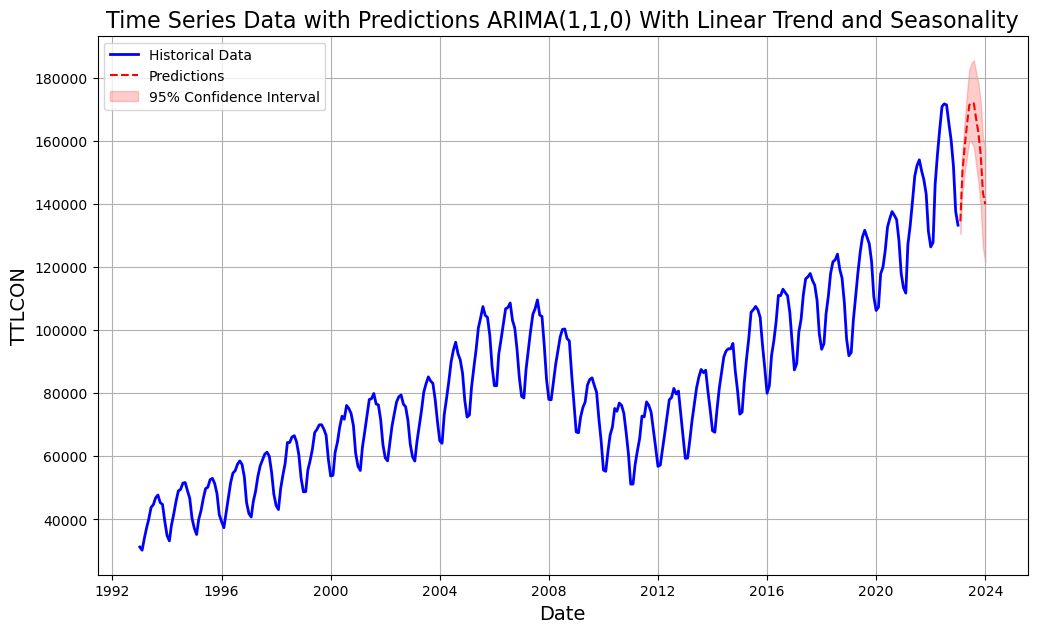

In [4]:
data['TTLCON'].index.freq = 'MS'

model=sm.tsa.statespace.SARIMAX(data['TTLCON'],order=(1, 1, 0), 
                                seasonal_order=(1, 0, 0, 12), trend = 't')
results=model.fit()
preds_df = (results.get_forecast(steps = 12)
            .summary_frame(alpha=0.05))
# Plotting the original data and the predictions with confidence intervals
plt.figure(figsize=(12, 7))

# Original data
plt.plot(data.index, data['TTLCON'], label='Historical Data', color='blue', linewidth=2)

# Predictions
plt.plot(preds_df.index, preds_df['mean'], label='Predictions', color='red', linestyle='--')

# Confidence intervals
plt.fill_between(preds_df.index, preds_df['mean_ci_lower'], preds_df['mean_ci_upper'], color='red', alpha=0.2, label='95% Confidence Interval')

# Beautifying the plot
plt.title('Time Series Data with Predictions ARIMA(1,1,0) With Linear Trend and Seasonality', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('TTLCON', fontsize=14)
plt.grid(True)
plt.legend()

plt.show()

## Machine Learning Example

In [5]:
# Add Target variable
data['Y'] = data['TTLCON'].diff()
data['Y_lag'] = data['TTLCON'].shift()

# add a seasonal lag
data['s_Y'] = data['TTLCON'].shift(12)

# Adding some features
data['change'] = data['TTLCON'].diff().shift()
data['S_change'] = data['change'].shift(12) 

# Add in monthly dummies
# Extracting month from the DataFrame's index
data['Month'] = data.index.month

# Creating dummy variables for the months
month_dummies = pd.get_dummies(data['Month'], prefix='Month')

# Joining the dummy variables back to the original DataFrame
data_with_dummies = data.join(month_dummies)
data_with_dummies.drop('Month', axis = 1, inplace = True)

# Add in linear trend
data_with_dummies['t'] = np.arange(1, len(data)+1)
data_with_dummies['t2'] = np.arange(1, len(data)+1)**2
data_with_dummies.dropna(inplace = True)

In [6]:
Y = data_with_dummies['Y']
X = data_with_dummies.iloc[:,2:]

## Cross-Validation Using Time Series Cross Validation

In [7]:
from sklearn.ensemble import RandomForestRegressor

In [8]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = [1.0, 'sqrt', 'log2']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 10)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [78]:
from sklearn.model_selection import TimeSeriesSplit

In [79]:
# Below we set the parameters for the splits we will use during cross validation
# Since max_train_size is None, we use an expanding window
tscv = TimeSeriesSplit(gap=0, n_splits = 5, max_train_size=None, test_size=12)

In [80]:
from sklearn.model_selection import GridSearchCV
# We run our grid search and specify that we will be using processors in parallel with n_jobs
# verbosity specifies how much information is transmitted after the search is ran
clf = GridSearchCV(estimator=RandomForestRegressor(), param_grid=random_grid, cv = tscv.split(X), scoring = 'neg_mean_squared_error', n_jobs = -1, verbose = 100)

In [12]:
# Now we run the actual fitting on each of the folds
clf.fit(X, Y)

Fitting 5 folds for each of 5940 candidates, totalling 29700 fits


KeyboardInterrupt: 

In [13]:
# here we put the corss avlidation results that are stored in the CLF object into a dataframe
cv_results = pd.DataFrame(clf.cv_results_)
cv_results

AttributeError: 'GridSearchCV' object has no attribute 'cv_results_'

## Final Prediction

In [8]:
regressor = RandomForestRegressor(n_estimators=800, random_state=0, bootstrap =False, max_depth = 21, max_features = 1.0, min_samples_leaf = 2,
                                 min_samples_split = 2)
regressor.fit(X, Y)

RandomForestRegressor(bootstrap=False, max_depth=21, min_samples_leaf=2,
                      n_estimators=800, random_state=0)

In [9]:
last = data['TTLCON'].iloc[-1]

In [10]:
last = 133247.0

In [11]:
test = pd.read_csv('TTLCON.csv', index_col = 0, parse_dates = True)

In [12]:
# Add Target variable
test['Y'] = test['TTLCON'].diff()
test['Y_lag'] = test['TTLCON'].shift()

# add a seasonal lag
test['s_Y'] = test['TTLCON'].shift(12)

# Adding some features
test['change'] = test['TTLCON'].diff().shift()
test['S_change'] = test['change'].shift(12) 

# Add in monthly dummies
# Extracting month from the DataFrame's index
test['Month'] = test.index.month

# Creating dummy variables for the months
month_dummies = pd.get_dummies(test['Month'], prefix='Month')

# Joining the dummy variables back to the original DataFrame
data_with_dummies = test.join(month_dummies)
data_with_dummies.drop('Month', axis = 1, inplace = True)

# Add in linear trend
data_with_dummies['t'] = np.arange(1, len(test)+1)
data_with_dummies['t2'] = np.arange(1, len(test)+1)**2
data_with_dummies.dropna(inplace = True)

In [13]:
testframe = data_with_dummies.iloc[-13:-1].copy()

In [14]:
X_test = testframe.iloc[:,2:].copy()

In [15]:
# recursrive forecast
last = 133247.0
predictions = []
for i in range(len(X_test)-1):
    c_pred = regressor.predict(X_test.iloc[i:i+1])
    last += c_pred
    X_test.loc[X_test.index[i+1], 'Y_lag'] = last
    X_test.loc[X_test.index[i+1], 'change'] = c_pred
    testframe.loc[X_test.index[i], 'prediction'] = last
    print(c_pred)
i = i+1

c_pred = regressor.predict(X_test.iloc[i:i+1])

last += c_pred
testframe.loc[X_test.index[i], 'prediction'] = last

[-310.]
[16869.]
[8701.]
[7391.5]
[7391.5]
[3613.66666667]
[7805.5]
[-3015.]
[-4049.5]
[-7947.5]
[-13107.]


## Bootstrap Confidence Intervals

Creating prediction intervals for machine learning models is not as straightforward as for most linear forecasts. For example "neural networks are not based on a well-defined stochastic model, and so it is not straightforward to derive prediction intervals for the resultant forecasts." 

source: https://otexts.com/fpp2/nnetar.html

However, this does not mean that forming prediction intervals around ML forecasts is impossible. Using bootstrapped residuals to simulate possible future paths to form these intervals is another popular alternative. 

In [16]:
from arch.bootstrap import MovingBlockBootstrap

In [17]:
bs = MovingBlockBootstrap(100, X.copy(), Y.copy())
bootstraps = pd.DataFrame( columns = ['TTLCON', 'prediction', 'steps'])
for i, t in enumerate(bs.bootstrap(1000)):

    # subset the train and test indices from the current fold
    xtemp_train = t[0][0]
    ytemp_train = t[0][1]

    # fit the model on the validation set
    regressor = RandomForestRegressor(n_estimators=800, random_state=0, bootstrap =False, max_depth = 21, max_features = 1.0, min_samples_leaf = 2,
                                 min_samples_split = 2)
    
    regressor.fit(xtemp_train, ytemp_train)
    # format the testing data
    # get the true values
    temp_y_test = pd.DataFrame(Y.loc[ytemp_train.index[-1]:,].iloc[1:14])

    # get the last observed value from the training set to make the first forecast
    last = data_with_dummies.loc[ytemp_train.index[-1], 'TTLCON']

    # Get the predictors
    Xtemp_test = X.loc[ytemp_train.index[-1]:,].iloc[1:14]
    for j in range(0, 12):
        #make a prediction
        tchange = regressor.predict(Xtemp_test.loc[Xtemp_test.index[j]:Xtemp_test.index[j]])

        #compute the "level" of the variable by adding teh change to the last value
        last += tchange 

        # Store the information
        temp_y_test.loc[Xtemp_test.index[j], 'prediction'] = last
        temp_y_test.loc[Xtemp_test.index[j], 'steps'] = j+1
        Xtemp_test.loc[Xtemp_test.index[j+1], 'change'] = tchange
        Xtemp_test.loc[Xtemp_test.index[j+1], 'Y_lag'] = last

    tchange = regressor.predict(Xtemp_test.loc[Xtemp_test.index[j+1]:Xtemp_test.index[j+1]])
    
    #compute the "level" of the variable by adding teh change to the last value
    last += tchange 
    
    # Store the information
    temp_y_test.loc[Xtemp_test.index[j], 'prediction'] = last
    temp_y_test.loc[Xtemp_test.index[j], 'steps'] = j+1
    bootstraps = pd.concat([bootstraps, temp_y_test])
    print(i)

/var/folders/8m/fffj5k3d19917rjhf2d4vhj00000gn/T/ipykernel_37067/1041618617.py:44: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  bootstraps = pd.concat([bootstraps, temp_y_test])
/var/folders/8m/fffj5k3d19917rjhf2d4vhj00000gn/T/ipykernel_37067/1041618617.py:44: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  bootstraps = pd.concat([bootstraps, temp_y_test])


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [18]:
bootstraps['TTLCON'] = data['TTLCON']

In [19]:
# here we pull out the pbootstrapped residuals to form the prediction interval
bootstraps['residuals'] = bootstraps['TTLCON'] - bootstraps['prediction']

In [20]:
bootstraps['steps']

2006-08-01     1.0
2006-09-01     2.0
2006-10-01     3.0
2006-11-01     4.0
2006-12-01     5.0
              ... 
2009-08-01     9.0
2009-09-01    10.0
2009-10-01    11.0
2009-11-01    12.0
2009-12-01     NaN
Name: steps, Length: 13000, dtype: float64

In [21]:
# get the bootsrapped samples (we should uyse many more for a real interval, but this takes a while to compute predictions over many bootstrapped samples)
samples = [bootstraps.loc[bootstraps['steps'] == i,'residuals'].sample(1000, replace = True).values for i in range(1,13)]

In [22]:
samples = pd.DataFrame(samples, index = X_test.index)

In [23]:
samples

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
DATE,,,,,,,,,,,,,,,,,,,,,
2023-02-01,-1107.000000,1645.333333,-67.335000,-1063.968750,641.889375,0.000000,388.333333,3217.738750,0.000000,114.000000,...,2040.333333,2315.045000,1972.666667,-244.302500,273.000000,-388.000000,-2789.795000,635.821875,622.000000,2244.425000
2023-03-01,-683.825000,3456.168750,-1835.000000,2773.500000,-1230.986667,96.420000,-1227.500000,0.000000,-392.891875,-546.000000,...,788.853333,-107.000000,-898.000000,-533.223333,-224.666667,2143.497500,0.000000,92.666667,-2323.890417,1342.000000
2023-04-01,-6146.316667,98.919167,-24.000000,3237.401250,-6501.768125,29.250000,-991.500000,2586.581250,-2589.291667,-140.000000,...,146.666667,857.625000,0.000000,-2252.557083,-877.843750,-4763.847500,-271.000000,-37.564167,886.972083,-391.562500
2023-05-01,-2679.850000,364.333333,-206.000000,-26.333333,283.354583,236.890625,-489.666667,0.000000,-2147.374583,1961.833333,...,-2082.197500,-3981.832500,-2418.333333,81.333333,-3284.500000,-2101.407083,3836.950000,178.560000,-68.241667,-335.722917
2023-06-01,-1259.666667,-1118.333333,-1028.799375,694.972917,368.716667,767.956667,0.000000,96.420000,279.161250,1.333333,...,1924.166667,-148.166667,5054.529583,80.000000,1223.022500,-513.833333,-237.500000,-516.232500,-1720.806667,54.000000
2023-07-01,-12543.602083,3172.494583,942.833333,0.000000,579.347500,-1008.878333,-3388.896667,1131.233333,-3664.741875,-3388.896667,...,260.333333,-85.114375,-54.497500,7254.576250,154.666667,-139.000000,2372.499375,-277.000000,204.333333,715.785208
2023-08-01,-629.833333,1406.155208,-1550.825000,-59.583333,-4984.600833,-5027.130417,-455.666667,-59.666667,370.522708,-831.500000,...,2508.436042,1008.666667,71.416667,4023.373750,-3240.709583,129.843542,-7887.015625,3045.585833,614.450000,14253.291667
2023-09-01,-982.000000,-3061.255417,1373.625000,-636.333333,15419.102917,-40.666667,332.666667,-4738.691667,8662.420833,-4374.654792,...,-8727.582708,-2798.419583,-617.083333,-2004.300625,1376.670417,-683.397917,-12522.713333,3664.660833,-826.540208,-1133.650417
2023-10-01,195.020000,-7235.082708,-2369.583333,-254.074167,516.536667,-8499.697083,1102.347500,-99.753333,450.666667,-4813.703333,...,-7672.763750,-7390.861667,-477.833333,2777.502292,210.893333,-990.156042,-6482.142083,-2992.957500,1583.947500,924.799167


In [24]:
# below we aree creating the bootstrapped prediction paths by adding residuals to our original predictions
for i in samples.index:
    samples.loc[i] = samples.loc[i] + testframe.loc[i, 'prediction']

In [25]:
testframe.loc[:,'prediction']

DATE
2023-02-01    132937.000000
2023-03-01    149806.000000
2023-04-01    158507.000000
2023-05-01    165898.500000
2023-06-01    173290.000000
2023-07-01    176903.666667
2023-08-01    184709.166667
2023-09-01    181694.166667
2023-10-01    177644.666667
2023-11-01    169697.166667
2023-12-01    156590.166667
2024-01-01    152193.833333
Name: prediction, dtype: float64

In [26]:
data = pd.read_csv('TTLCON.csv', index_col = 0, parse_dates = True)

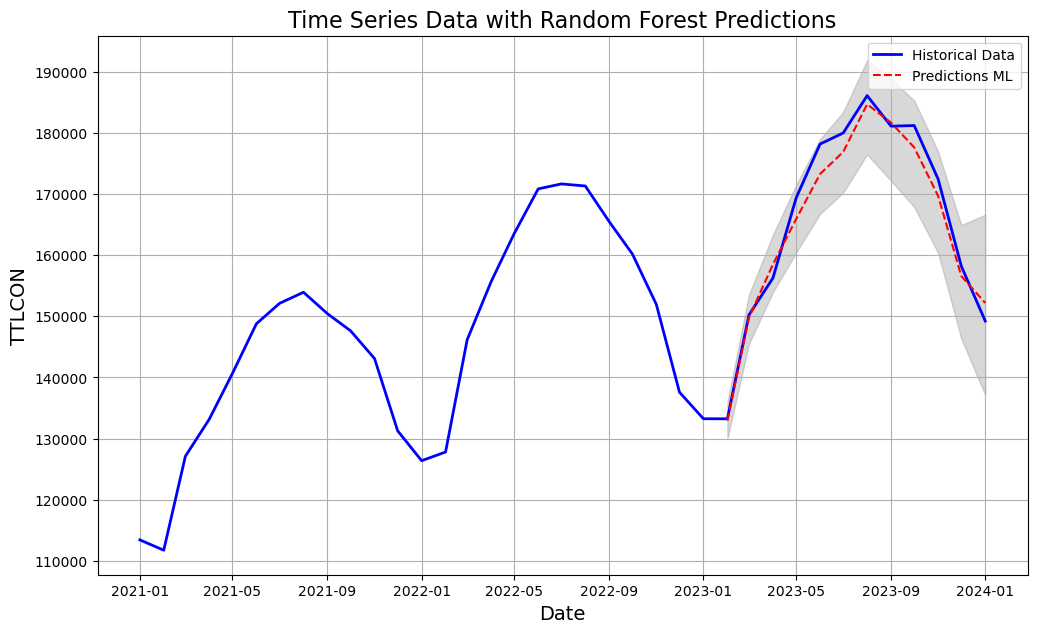

In [27]:
# Plotting the original data and the predictions with confidence intervals
plt.figure(figsize=(12, 7))

# Original data
plt.plot(data.loc[data.index.year> 2020,'TTLCON'][:-1], label='Historical Data', color='blue', linewidth=2)

# Predictions
plt.plot(testframe.index, testframe['prediction'], label='Predictions ML', color='red', linestyle='--')
#plt.plot(preds_df.index, preds_df['mean'], label='Predictions ARIMA', color='green', linestyle='--')

plt.fill_between(samples.index, samples.quantile(.025, axis = 1), samples.quantile(.975, axis = 1), color= 'grey', alpha = .3)

# Confidence intervals
#plt.fill_between(preds_df.index, preds_df['mean_ci_lower'], preds_df['mean_ci_upper'], color='red', alpha=0.2, label='95% Confidence Interval')

# Beautifying the plot
plt.title('Time Series Data with Random Forest Predictions', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('TTLCON', fontsize=14)
plt.grid(True)
plt.legend()

plt.show()

In [28]:
((testframe['TTLCON'] - testframe['prediction'])**2).mean()

7077720.384259254

In [29]:
((testframe['TTLCON'] - preds_df['mean'])**2).mean()

123189065.48277307

In [30]:
123189065.48277307-84942143.73555313

38246921.747219935